# Getting started with the OpenDSM library

This jupyter notebook is an interactive tutorial. It walks through loading data, utilizing OpenEEmeter models, and plotting results. You'll run all the code yourself. Cells can be executed with `<shift><enter>`. Feel free to make edits to the code in these cells and dig deeper.

### Note on tutorial scope

This tutorial assumes the reader has properly installed python and the OpenDSM package (`pip install opendsm`) and has a basic working knowledge of python syntax and usage.

## Outline

This tutorial is a walkthrough of how to use the OpenDSM package. We'll cover the following:

- Background - why this library
- Loading data
- Fitting OpenEEmeter models
- Prediction of fit models
- Computing metered savings

The tutorial is focused on demonstrating how to use the package to run the Hourly, Daily, and Billing models.

## Background and Cautions

[OpenDSM](https://lfenergy.org/projects/opendsm/) is an open-source library which can be used to calculate avoided energy consumption on an individual meter. It pulls weather data using `EEweather`, fits models on training (baseline) data using the `OpenEEmeter` module, predicts using those models on testing (reporting) data, and corrects models for population-level changes via `GRIDmeter`. This tutorial will focus on the OpenEEmeter portion of this sequence. OpenEEmeter is the successor of the [CalTRACK](http://www.caltrack.org/) methodology. Initially OpenEEmeter was the complete open source implementation of the CalTRACK methodology, but it has since evolved beyond the CalTRACK models.

The `OpenEEmeter` module is built for flexibility and modularity. While this makes it easier to use the package, without following the documentation and the guidance provided, it is very possible to use the module in a way that does not comply with the approved methodology. For example, while the `OpenEEmeter` models set specific hard limits for the purpose of standardization and consistency, they can be configured to edit or entirely ignore those limits. The reason for this flexibility is to facilitate research, development, and testing of potential changes to the models. Usage of `OpenEEmeter` does not in itself guarantee compliance with the accepted methodology if nondefault configurations are used.

Some new users have assumed that the OpenDSM package constitutes an entire application suitable for running metering analytics at scale. This is not necessarily the case. It is designed instead to be embedded within other applications or to be used in one-off analyses. OpenDSM leaves it up to the user to decide when to use or how to embed the provided tools within other applications. This limitation is an important consequence of the decision to make the models and tools as open and accessible as possible as not all users will have access to enterprise-level infrastructure.

As you dive in, remember that this is a work in progress and that we welcome feedback and contributions. To contribute, please open an [issue](https://github.com/opendsm/opendsm/issues) or a [pull request](https://github.com/opendsm/opendsm/pulls) on github.

### Jupyter housekeeping

*Note: these Jupyter cell magics enable some useful special features but are unrelated to eemeter.*

In [1]:
# inline plotting
%matplotlib inline

# allow live package editing
%load_ext autoreload
%autoreload 2

# Importing the OpenDSM library

Once the OpenDSM has been installed, it can be imported as shown below.

This tutorial requires OpenDSM version > 1.2.x. Verify the version you have installed.

We will load eemeter and drmeter modules separately

In [2]:
import numpy as np
import pandas as pd

import opendsm as odsm
from opendsm import (
    eemeter as em,
    drmeter as dm,
)

print(f"OpenDSM {odsm.__version__}")

OpenDSM 1.2.6


## Loading data

The essential inputs to OpenDSM library functions are the following:

1. Meter baseline data named `observed`
2. Meter reporting data `observed`
3. Temperature data from a nearby weather station for both named `temperature`
4. All data is expected to have a timezone-aware datetime index or column named `datetime`

Users of the library are responsible for obtaining and formatting this data (to get weather data, see [eeweather](https://eeweather.openee.io/), which helps perform site to weather station matching and can pull and cache temperature data directly from public (US) data sources). Some samples come loaded with the library and we'll load these first to save you the trouble of loading in your own data.

We utilize data classes to store meter data, perform transforms, and validate the data to ensure data compliance. The inputs into these data classes can either be [pandas](https://pandas.pydata.org/) `DataFrame` if initializing the classes directly or `Series` if initializing the classes using `.from_series`.

The test data contained within the OpenDSM library is derived from [NREL ComStock](https://comstock.nrel.gov/) simulations.

If working with your own data instead of these samples, please refer directly to the excellent pandas documentation for instructions for loading data (e.g., [pandas.read_csv](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html)).

### Important notes about data:
- *These models were developed and tested using Fahrenheit temperature. Please convert your temperatures accordingly*
- *It is expected that all data is trimmed to its appropriate time period (baseline and reporting) and does not contain extraneous datetimes*
- *If you run load_test_data it will download the necessary files from the OpenDSM repository. This can be up to 150 MB*

In [3]:
# Load in test data
#     - This data contains 100 different meters

df_baseline, df_reporting = odsm.test_data.load_test_data("daily_treatment_data")

## Daily model

### Create the baseline and reporting data objects

- It is necessary to specify if data is electric or not due to differences in disqualification criteria
- Hourly temperature data can (and should) be input with daily observed data. If this is done as a dataframe, then the observed data should have 1 value per day and the rest NaN

In [4]:
# Choose which meter you would like to use in the following analysis
n = 15

id = df_baseline.index.get_level_values(0).unique()[n]

df_baseline_n = df_baseline.loc[id]
df_reporting_n = df_reporting.loc[id]

daily_baseline_data = em.DailyBaselineData(df_baseline_n, is_electricity_data=True)
daily_reporting_data = em.DailyReportingData(df_reporting_n, is_electricity_data=True)

{'n_extreme_values': 8, 'median': 2697.2358494980817, 'upper_quantile': 3269.296428540127, 'lower_quantile': 2315.7411394245737, 'lower_bound': -544.9247279220867, 'upper_bound': 6129.962295886788, 'min_value': 1181.0132889040156, 'max_value': 9629.679232340746}


Data classes can also be instantiated using `from_series`. This method is more similar to that of previous eemeter releases

In [5]:
df_baseline, df_reporting = odsm.test_data.load_test_data("hourly_treatment_data")

df_baseline_n = df_baseline.loc[id]
df_reporting_n = df_reporting.loc[id]

# separate the data into series
baseline_n_temperature= df_baseline_n["temperature"]
baseline_n_observed = df_baseline_n["observed"]

# keep the temperature as hourly (like it would be coming out of eeweather) and resample observed to daily
baseline_n_observed = baseline_n_observed.resample("D").sum()

daily_baseline_data = em.DailyBaselineData.from_series(
    meter_data = baseline_n_observed, 
    temperature_data = baseline_n_temperature,
    is_electricity_data=True
    )

{'n_extreme_values': 8, 'median': 2697.2358494980817, 'upper_quantile': 3269.296428540127, 'lower_quantile': 2315.7411394245737, 'lower_bound': -544.9247279220867, 'upper_bound': 6129.962295886788, 'min_value': 1181.0132889040156, 'max_value': 9629.679232340746}


### How to access the disqualification and warnings attributes

- In this example, the data has no disqualifications

In [6]:
print(f"Disqualifications: {daily_baseline_data.disqualification}")
print(f"Warnings:          {daily_baseline_data.warnings}")

Disqualifications: []
Warnings:          [EEMeterWarning(qualified_name=eemeter.sufficiency_criteria.extreme_values_detected)]


### How to access the data object's dataframe used by the model

- Notice that it has added additional columns needed by the Daily model

In [7]:
daily_baseline_data.df.head()

,season,weekday_weekend,temperature,observed
datetime,,,,
2018-01-01 00:00:00-06:00,winter,weekday,-10.0450,9629.679232
2018-01-02 00:00:00-06:00,winter,weekday,-4.7125,8868.878051
2018-01-03 00:00:00-06:00,winter,weekday,11.3525,6109.322326
2018-01-04 00:00:00-06:00,winter,weekday,0.9725,7557.067633
2018-01-05 00:00:00-06:00,winter,weekday,3.1475,6650.189107


### How to use the Daily model

All models follow the same general format of:

- Initialize
- Fit
- Predict

We can initialize and fit in the same line (like below) as a shorthand or this can be done in separate steps

In [8]:
daily_model = em.DailyModel().fit(daily_baseline_data)

{'n_extreme_values': 8, 'median': 2697.2358494980817, 'upper_quantile': 3269.296428540127, 'lower_quantile': 2315.7411394245737, 'lower_bound': -544.9247279220867, 'upper_bound': 6129.962295886788, 'min_value': 1181.0132889040156, 'max_value': 9629.679232340746}


Once the model is fit, we can then use that intantiated model object to predict on a reporting data object that returns a dataframe with the predicted values as well as other useful information.

The predict class accepts baseline or reporting data objects.

In [9]:
df_results = daily_model.predict(daily_reporting_data)
df_results.head()

,season,day_of_week,weekday_weekend,temperature,observed,predicted,predicted_unc,heating_load,cooling_load,model_split,model_type
datetime,,,,,,,,,,,
2019-01-01 00:00:00-06:00,winter,2,weekday,-10.0450,6821.633670,8458.769369,403.385708,6145.508305,0.0,wd-su_sh_wi,hdd_tidd_cdd_smooth
2019-01-02 00:00:00-06:00,winter,3,weekday,-4.7125,5668.980225,7829.167990,403.385708,5515.906926,0.0,wd-su_sh_wi,hdd_tidd_cdd_smooth
2019-01-03 00:00:00-06:00,winter,4,weekday,11.3525,3122.794390,5960.086410,403.385708,3646.825346,0.0,wd-su_sh_wi,hdd_tidd_cdd_smooth
2019-01-04 00:00:00-06:00,winter,5,weekday,0.9725,3880.896300,7161.729548,403.385708,4848.468484,0.0,wd-su_sh_wi,hdd_tidd_cdd_smooth
2019-01-05 00:00:00-06:00,winter,6,weekend,3.1475,3182.209058,5213.370264,285.516312,3858.054437,0.0,we-su_sh_wi,hdd_tidd_cdd_smooth


### How to see basic visualizations

The model classes also have built into them some basic visualization functions in the form of `plot` that requires a data object from the appropriate model

Baseline Data Figure


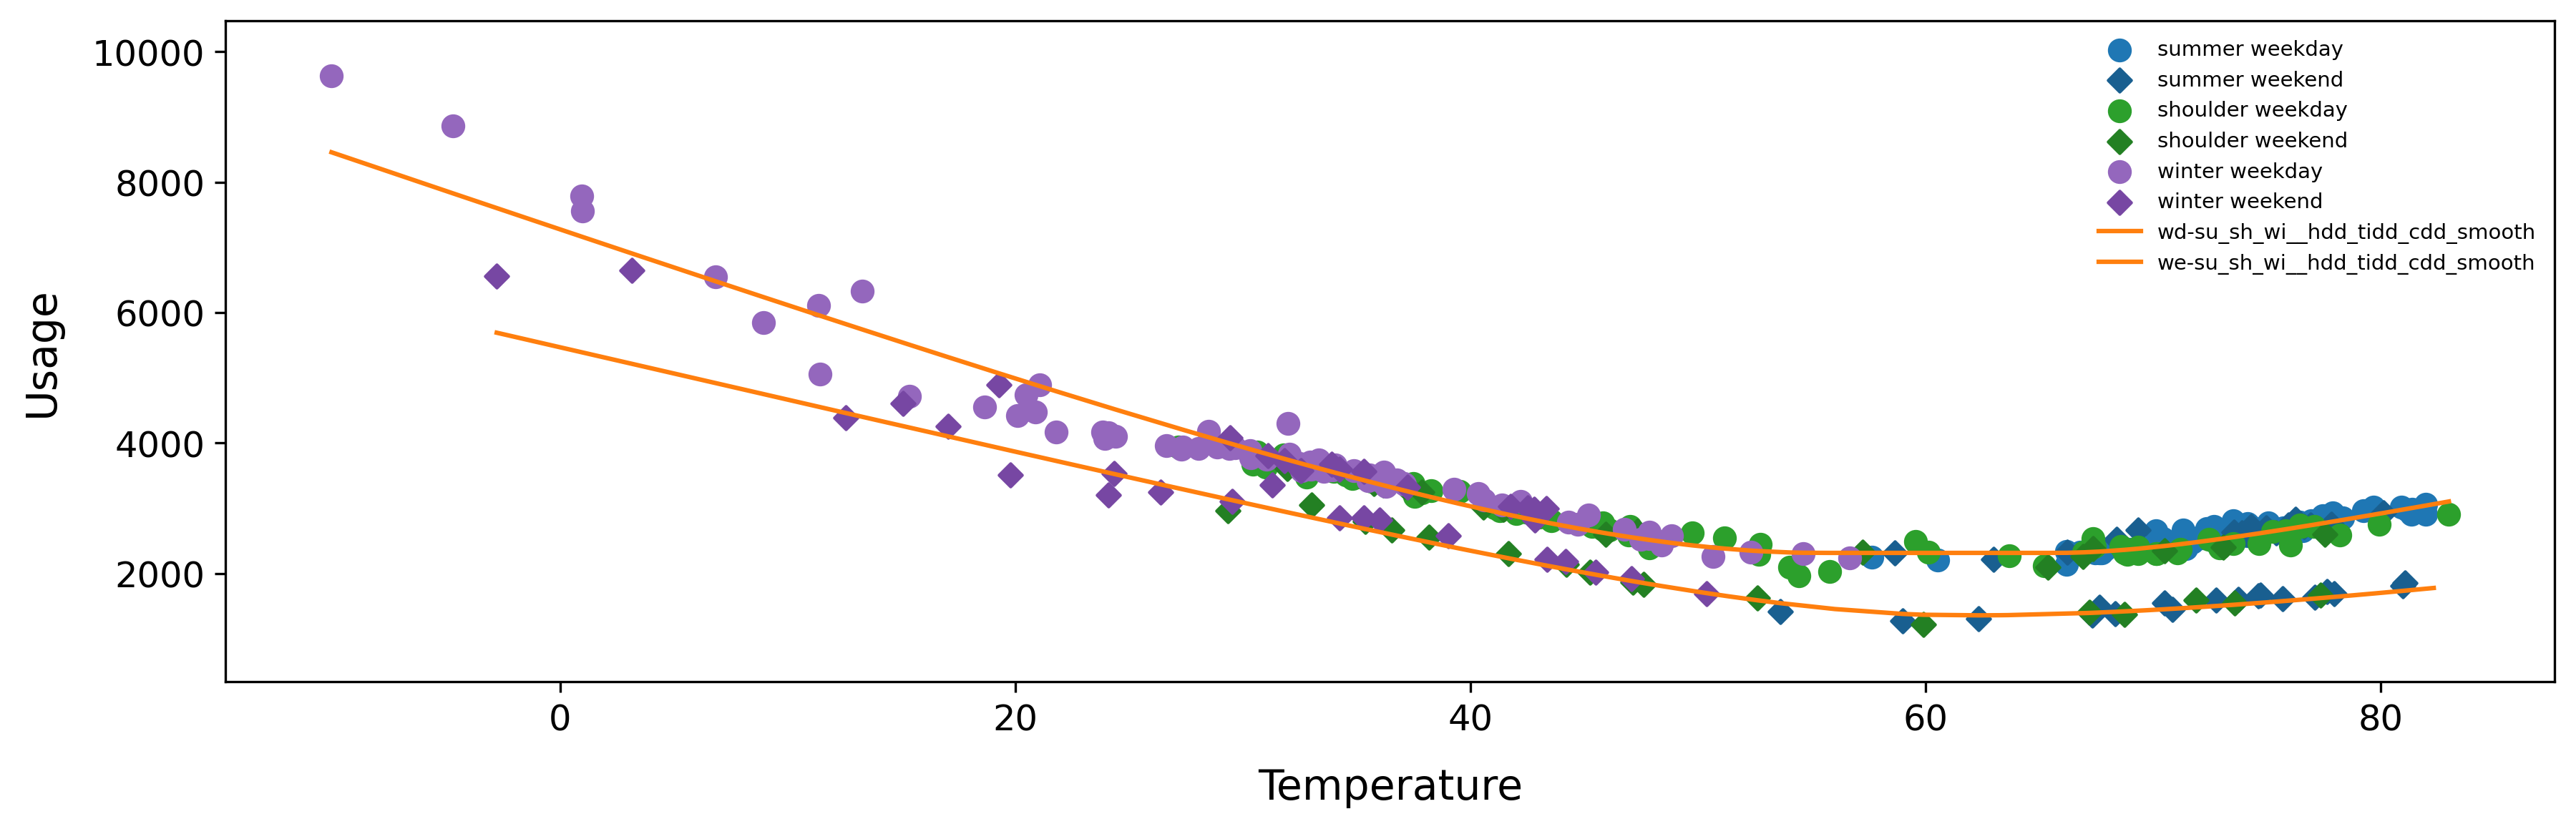

Reporting Data Figure


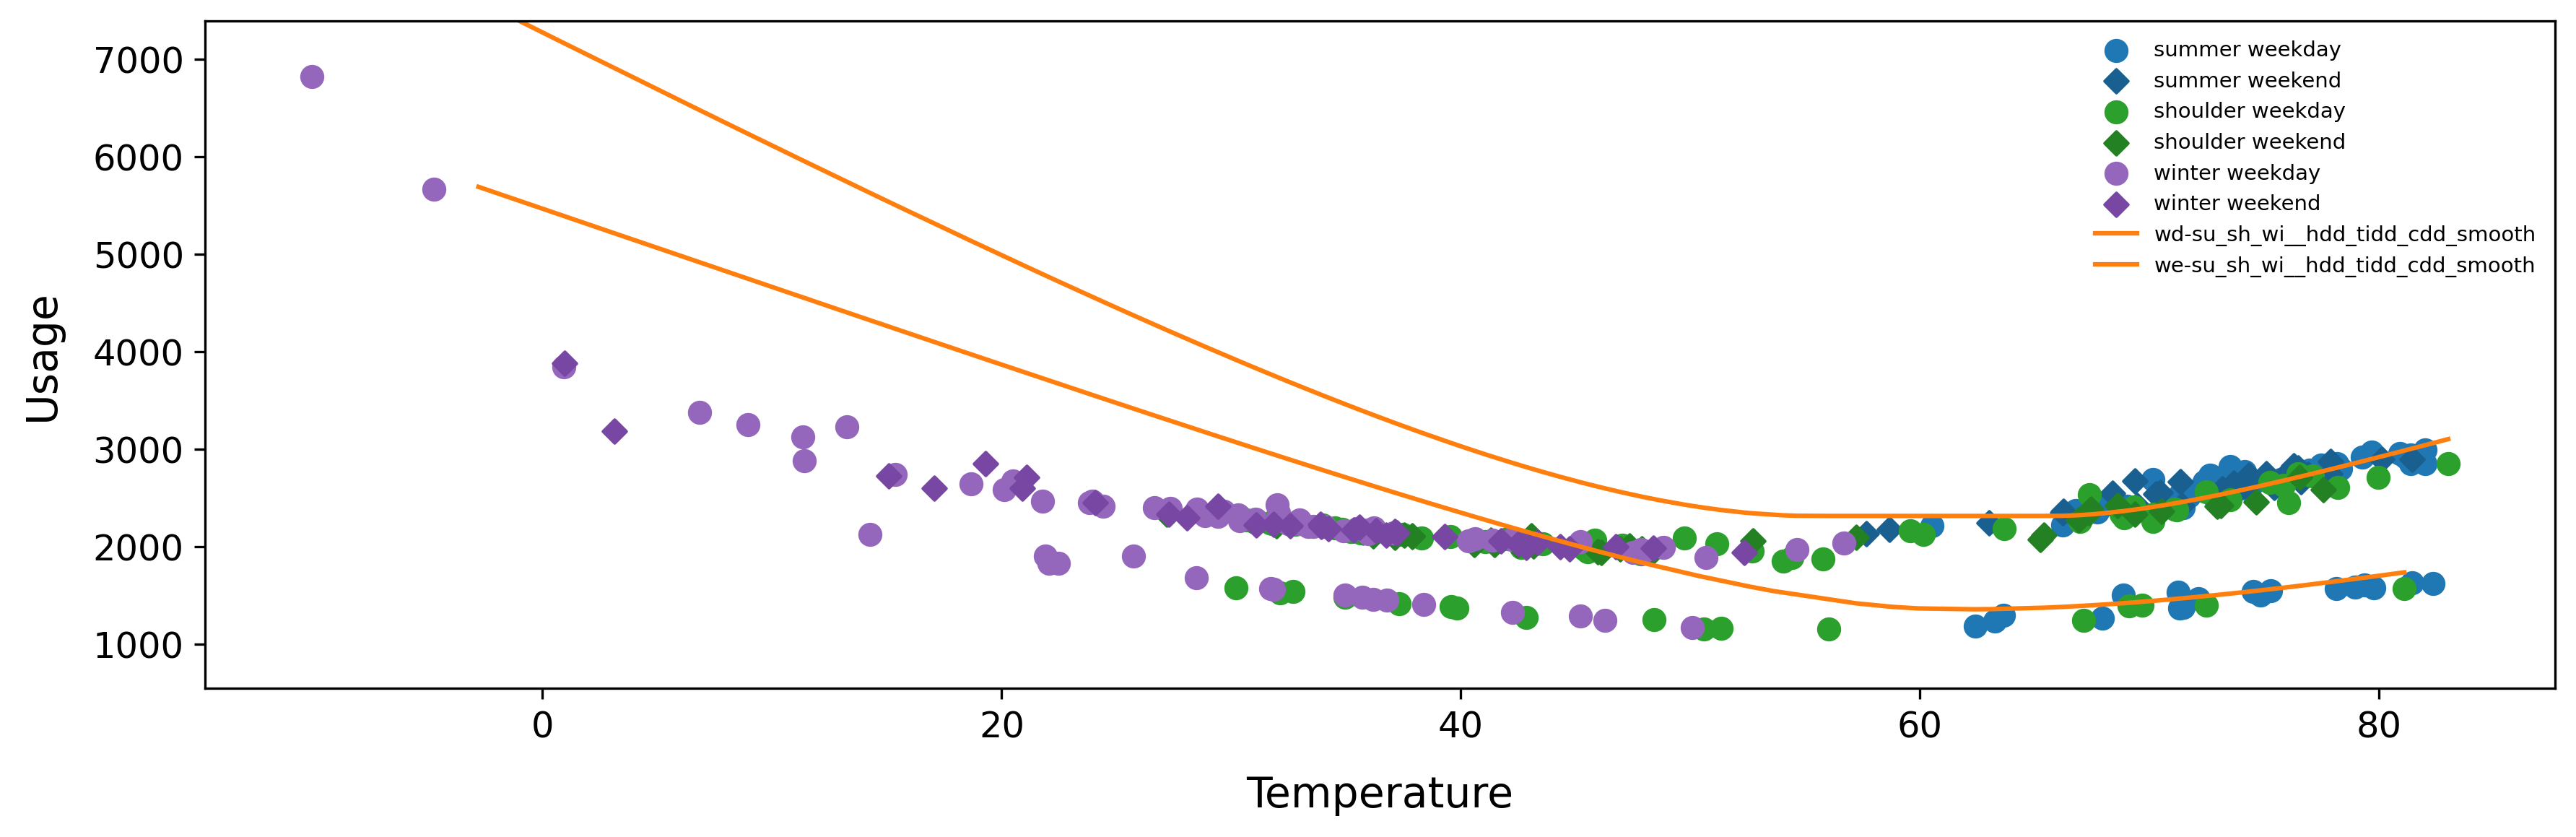

In [10]:
print("Baseline Data Figure")
daily_model.plot(daily_baseline_data)
print("Reporting Data Figure")
daily_model.plot(daily_reporting_data)

### What happens with data that has a problem?

Let's introduce a problem by setting too many observed values to NaN

In [11]:
daily_baseline_data_DQ = em.DailyBaselineData.from_series(
    meter_data = baseline_n_observed, 
    temperature_data = baseline_n_temperature,
    is_electricity_data=True
    )

# set rows 1:38 of observed to nan
df_baseline_n = daily_baseline_data_DQ.df
df_baseline_n.loc[df_baseline_n.index[1:37], "observed"] = np.nan

daily_baseline_data_DQ = em.DailyBaselineData(df_baseline_n, is_electricity_data=True)

{'n_extreme_values': 8, 'median': 2697.2358494980817, 'upper_quantile': 3269.296428540127, 'lower_quantile': 2315.7411394245737, 'lower_bound': -544.9247279220867, 'upper_bound': 6129.962295886788, 'min_value': 1181.0132889040156, 'max_value': 9629.679232340746}
{'n_extreme_values': 1, 'median': 2650.1957057228296, 'upper_quantile': 3012.864167593465, 'lower_quantile': 2306.423953117234, 'lower_bound': 187.10330968854032, 'upper_bound': 5132.184811022158, 'min_value': 1181.0132889040156, 'max_value': 9629.679232340746}
{'n_valid_observed_data_days': 328, 'n_days_total': 365.0}
{'n_valid_joint_data_days': 328, 'n_days_total': 365.0}


Now if we show the disqualifications and warnings we see that the data is disqualified because it has too many missing days in a month

In [12]:
print(f"Disqualifications: {daily_baseline_data_DQ.disqualification}")
print(f"Warnings:          {daily_baseline_data_DQ.warnings}")

Disqualifications: [EEMeterWarning(qualified_name=eemeter.sufficiency_criteria.too_many_days_with_missing_observed_data), EEMeterWarning(qualified_name=eemeter.sufficiency_criteria.too_many_days_with_missing_joint_data)]
Warnings:          [EEMeterWarning(qualified_name=eemeter.sufficiency_criteria.unable_to_confirm_daily_temperature_sufficiency), EEMeterWarning(qualified_name=eemeter.sufficiency_criteria.extreme_values_detected)]


If a model is trying to `fit` or `predict` on disqualified data it will throw an exception. We'll show that this would create an error in a try/except statement

This behavior is enabled by default, but you can choose to override it as below

In [13]:
try:
    daily_model = em.DailyModel().fit(daily_baseline_data_DQ)
except Exception as e:
    print(f"Exception: {e}")

daily_model = em.DailyModel().fit(daily_baseline_data_DQ, ignore_disqualification=True)

{'n_extreme_values': 1, 'median': 2650.1957057228296, 'upper_quantile': 3012.864167593465, 'lower_quantile': 2306.423953117234, 'lower_bound': 187.10330968854032, 'upper_bound': 5132.184811022158, 'min_value': 1181.0132889040156, 'max_value': 9629.679232340746}
{'n_valid_observed_data_days': 328, 'n_days_total': 365.0}
{'n_valid_joint_data_days': 328, 'n_days_total': 365.0}
{'n_extreme_values': 1, 'median': 2650.1957057228296, 'upper_quantile': 3012.864167593465, 'lower_quantile': 2306.423953117234, 'lower_bound': 187.10330968854032, 'upper_bound': 5132.184811022158, 'min_value': 1181.0132889040156, 'max_value': 9629.679232340746}
{'n_valid_observed_data_days': 328, 'n_days_total': 365.0}
{'n_valid_joint_data_days': 328, 'n_days_total': 365.0}


Exception: Can't fit model on disqualified baseline data


## Model Serialization

- All models within eemeter have the ability to be serialized. This enables them to be saved and initialized from that saved state without having to repeat the fitting steps

In [14]:
saved_model = daily_model.to_json()
saved_model

'{"submodels": {"wd-su_sh_wi": {"coefficients": {"model_type": "hdd_tidd_cdd_smooth", "intercept": 2279.4063008525227, "hdd_bp": 47.146642630592865, "hdd_beta": 93.58881124018063, "hdd_k": 0.44307422409303504, "cdd_bp": 66.98275053054962, "cdd_beta": 47.43094767298811, "cdd_k": 0.11072520362963659}, "temperature_constraints": {"T_min": -10.045, "T_max": 83.00500000000001, "T_min_seg": 20.900000000000002, "T_max_seg": 81.38}, "f_unc": 328.12799230589343}, "we-su_sh_wi": {"coefficients": {"model_type": "hdd_tidd_cdd_smooth", "intercept": 1344.1828918341207, "hdd_bp": 56.90080765532014, "hdd_beta": 61.32166667326855, "hdd_k": 0.11897985329529973, "cdd_bp": 67.29773810457435, "cdd_beta": 26.98096320204961, "cdd_k": 0.32985471982874304}, "temperature_constraints": {"T_min": 19.79, "T_max": 82.34, "T_min_seg": 28.46375, "T_max_seg": 79.7525}, "f_unc": 156.06502941405716}}, "info": {"metrics": {"num_model_params": 14, "wrmse": 170.40377611689195, "n": 329, "n_prime": 307.9852069080619, "ddof"

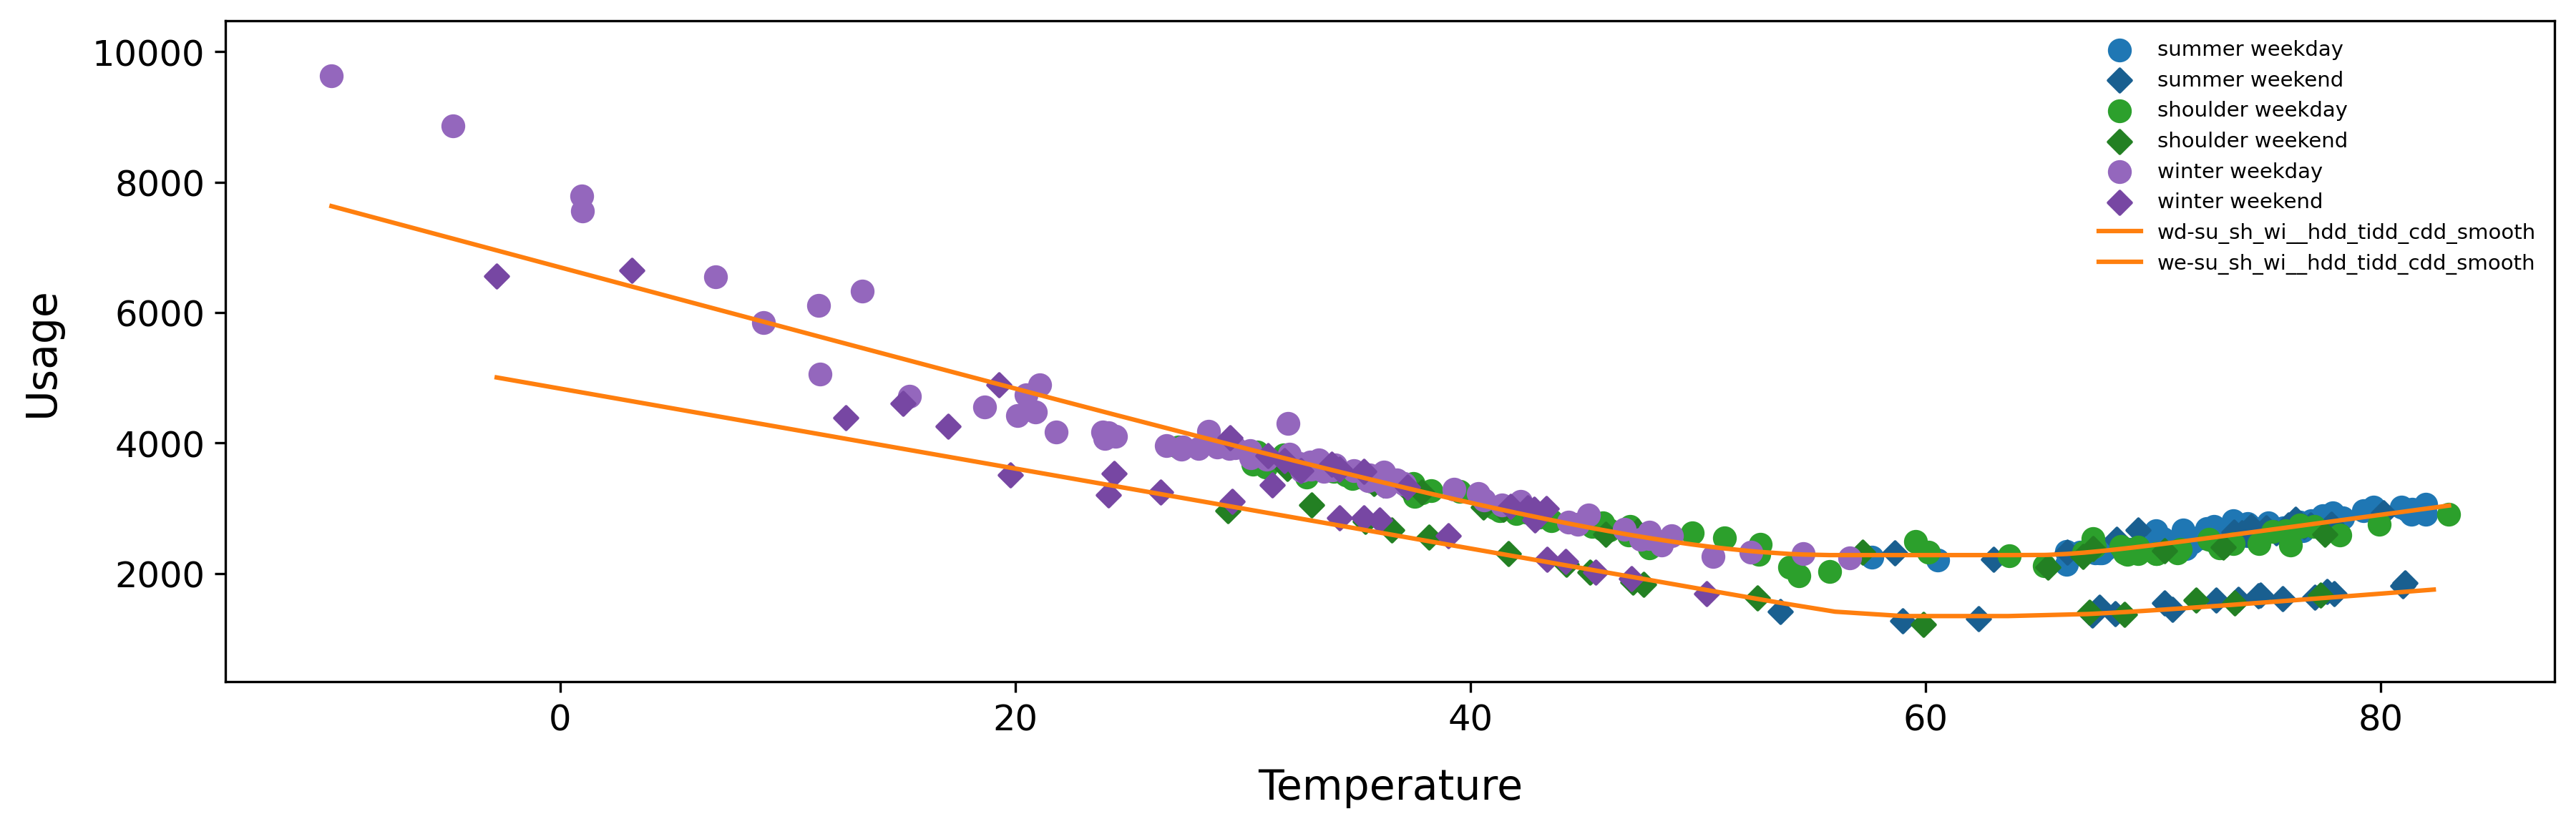

In [15]:
# Load the saved model and plot from it

daily_model = em.DailyModel.from_json(saved_model)
daily_model.plot(daily_baseline_data)

## BILLING EXAMPLE

Let's repeat this to show how the billing model works almost the same

In [16]:
df_baseline, df_reporting = odsm.test_data.load_test_data("monthly_treatment_data")

Note that the only difference in how these are called are the specific data classes and model used. Everything else remains the same.

- As with the Daily data, Billing data should have hourly temperature
- Billing data is reversed from a customer perspective. From a customer perspective, you pay for the month you used energy and so the bill is for the month prior. To model this, the start date should have the usage for a given month

In [17]:
n = 15

id = df_baseline.index.get_level_values(0).unique()[n]

df_baseline_n = df_baseline.loc[id]
df_reporting_n = df_reporting.loc[id]

billing_baseline_data = em.BillingBaselineData(df_baseline_n, is_electricity_data=True)
billing_reporting_data = em.BillingReportingData(df_reporting_n, is_electricity_data=True)

billing_model = em.BillingModel().fit(billing_baseline_data, ignore_disqualification=False)
billing_model.predict(billing_baseline_data).head()

,season,day_of_week,weekday_weekend,temperature,observed,predicted,predicted_unc,heating_load,cooling_load,model_split,model_type
datetime,,,,,,,,,,,
2018-01-01 00:00:00-06:00,winter,1,weekday,-10.0450,4629.919385,4688.669772,865.261233,2390.857575,0.0,fw-su_sh_wi,hdd_tidd
2018-01-02 00:00:00-06:00,winter,2,weekday,-4.7125,4629.919385,4524.738288,865.261233,2226.926092,0.0,fw-su_sh_wi,hdd_tidd
2018-01-03 00:00:00-06:00,winter,3,weekday,11.3525,4629.919385,4030.868756,865.261233,1733.056559,0.0,fw-su_sh_wi,hdd_tidd
2018-01-04 00:00:00-06:00,winter,4,weekday,0.9725,4629.919385,4349.970265,865.261233,2052.158068,0.0,fw-su_sh_wi,hdd_tidd
2018-01-05 00:00:00-06:00,winter,5,weekday,3.1475,4629.919385,4283.106510,865.261233,1985.294313,0.0,fw-su_sh_wi,hdd_tidd


The billing model prediction function does have additional functionality built into it where it can aggregate from averaged daily data to `monthly` or `bimonthly`

In [18]:
billing_model.predict(billing_baseline_data, aggregation="monthly")

,season,temperature,observed,predicted,predicted_unc,heating_load,cooling_load,model_split,model_type
datetime,,,,,,,,,
2018-01-01 00:00:00-06:00,winter,23.684855,143527.500929,113204.189203,4817.570659,41972.011102,0.0,fw-su_sh_wi,hdd_tidd
2018-02-01 00:00:00-06:00,winter,32.858562,96860.238591,94352.449401,4578.532084,30013.707891,0.0,fw-su_sh_wi,hdd_tidd
2018-03-01 00:00:00-06:00,shoulder,37.629977,94950.536848,99914.478306,4817.570659,28682.300206,0.0,fw-su_sh_wi,hdd_tidd
2018-04-01 00:00:00-05:00,shoulder,45.590826,78647.125698,89349.469105,4739.230955,20415.103201,0.0,fw-su_sh_wi,hdd_tidd
2018-05-01 00:00:00-05:00,shoulder,72.356294,67851.035861,71439.541663,4817.570659,207.363562,0.0,fw-su_sh_wi,hdd_tidd
2018-06-01 00:00:00-05:00,summer,74.298938,69477.868976,68966.564044,4739.230955,32.198140,0.0,fw-su_sh_wi,hdd_tidd
2018-07-01 00:00:00-05:00,summer,73.144887,71653.758200,71418.504666,4817.570659,186.326565,0.0,fw-su_sh_wi,hdd_tidd
2018-08-01 00:00:00-05:00,summer,74.186293,74378.979596,71453.264321,4817.570659,221.086220,0.0,fw-su_sh_wi,hdd_tidd
2018-09-01 00:00:00-05:00,summer,70.770046,66139.271122,70980.566635,4739.230955,2046.200731,0.0,fw-su_sh_wi,hdd_tidd


Similarly, the plot function also has the ability to aggregate to `monthly` or `bimonthly`. 

This model is still at its core, a modified daily model though. This is why the model prediction is not straight for either of the aggregations.

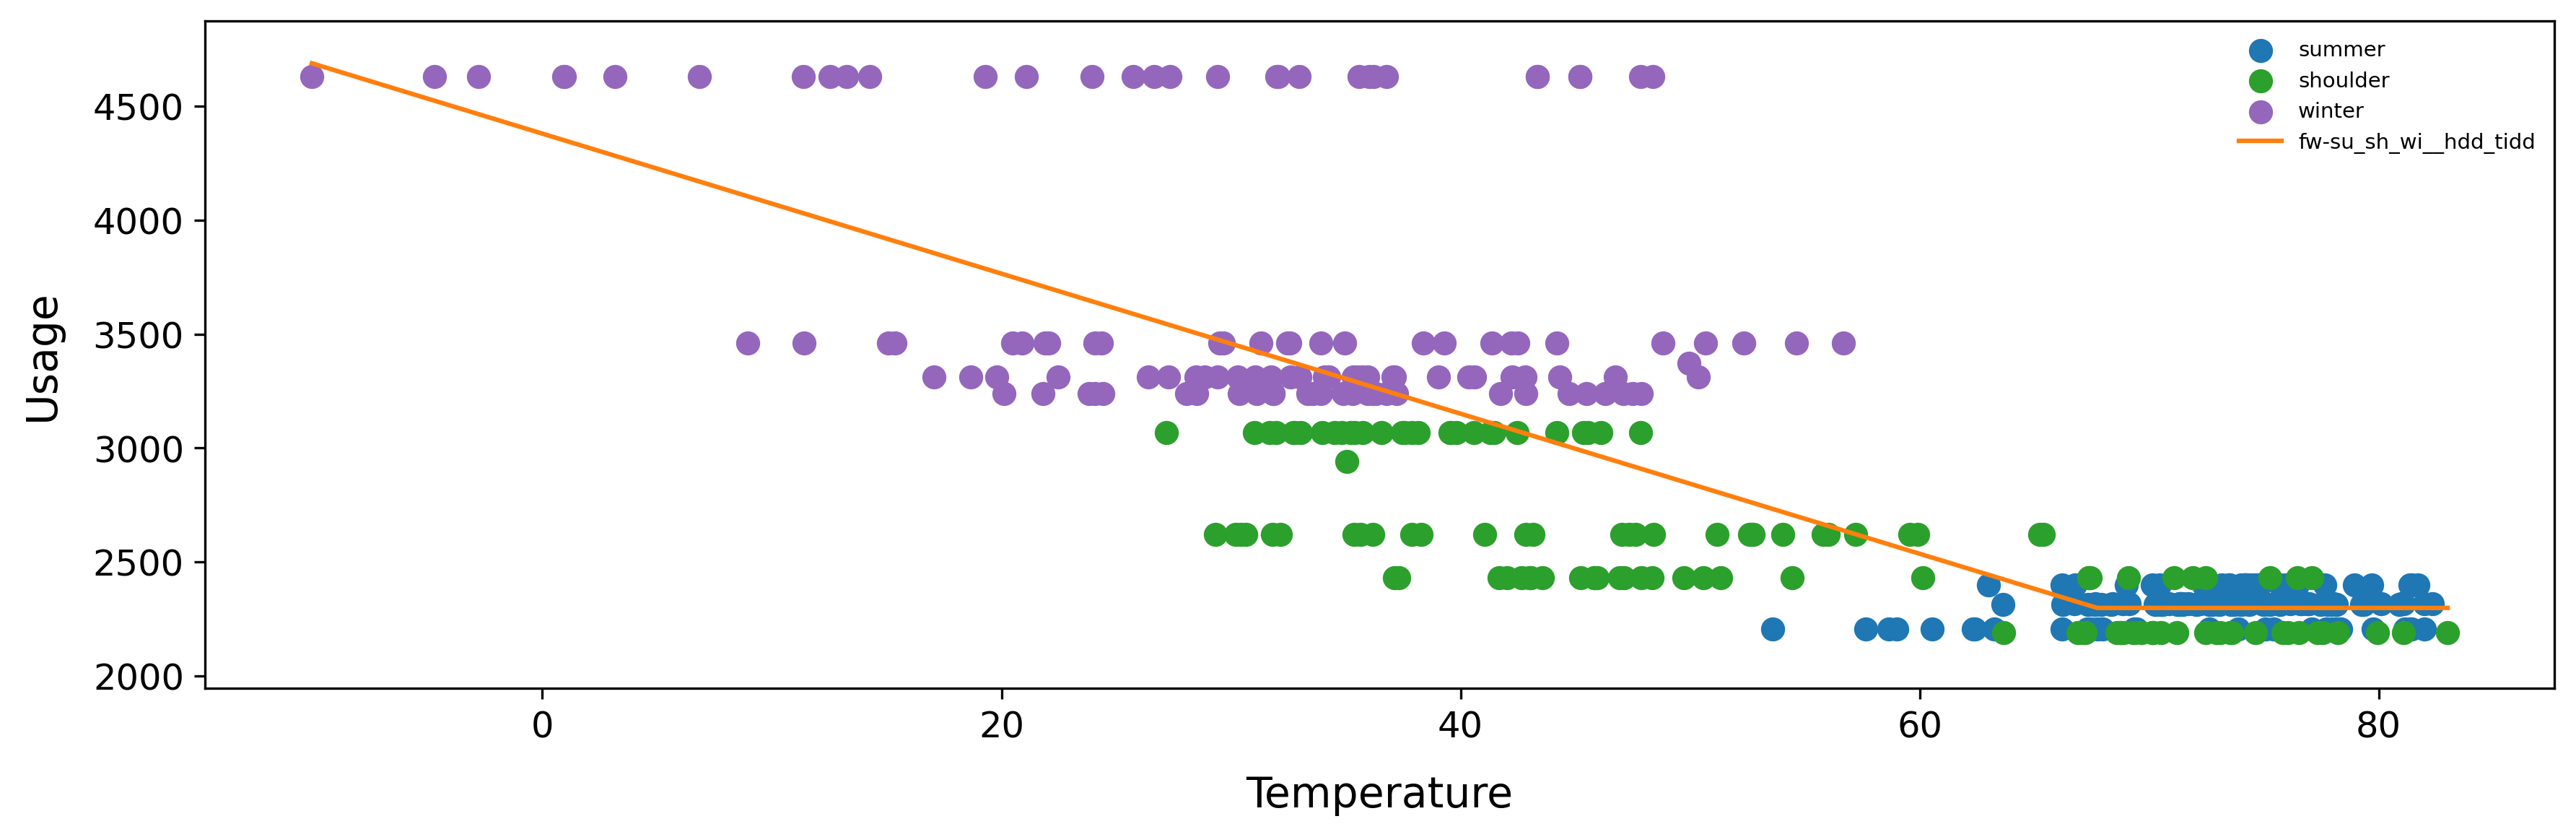

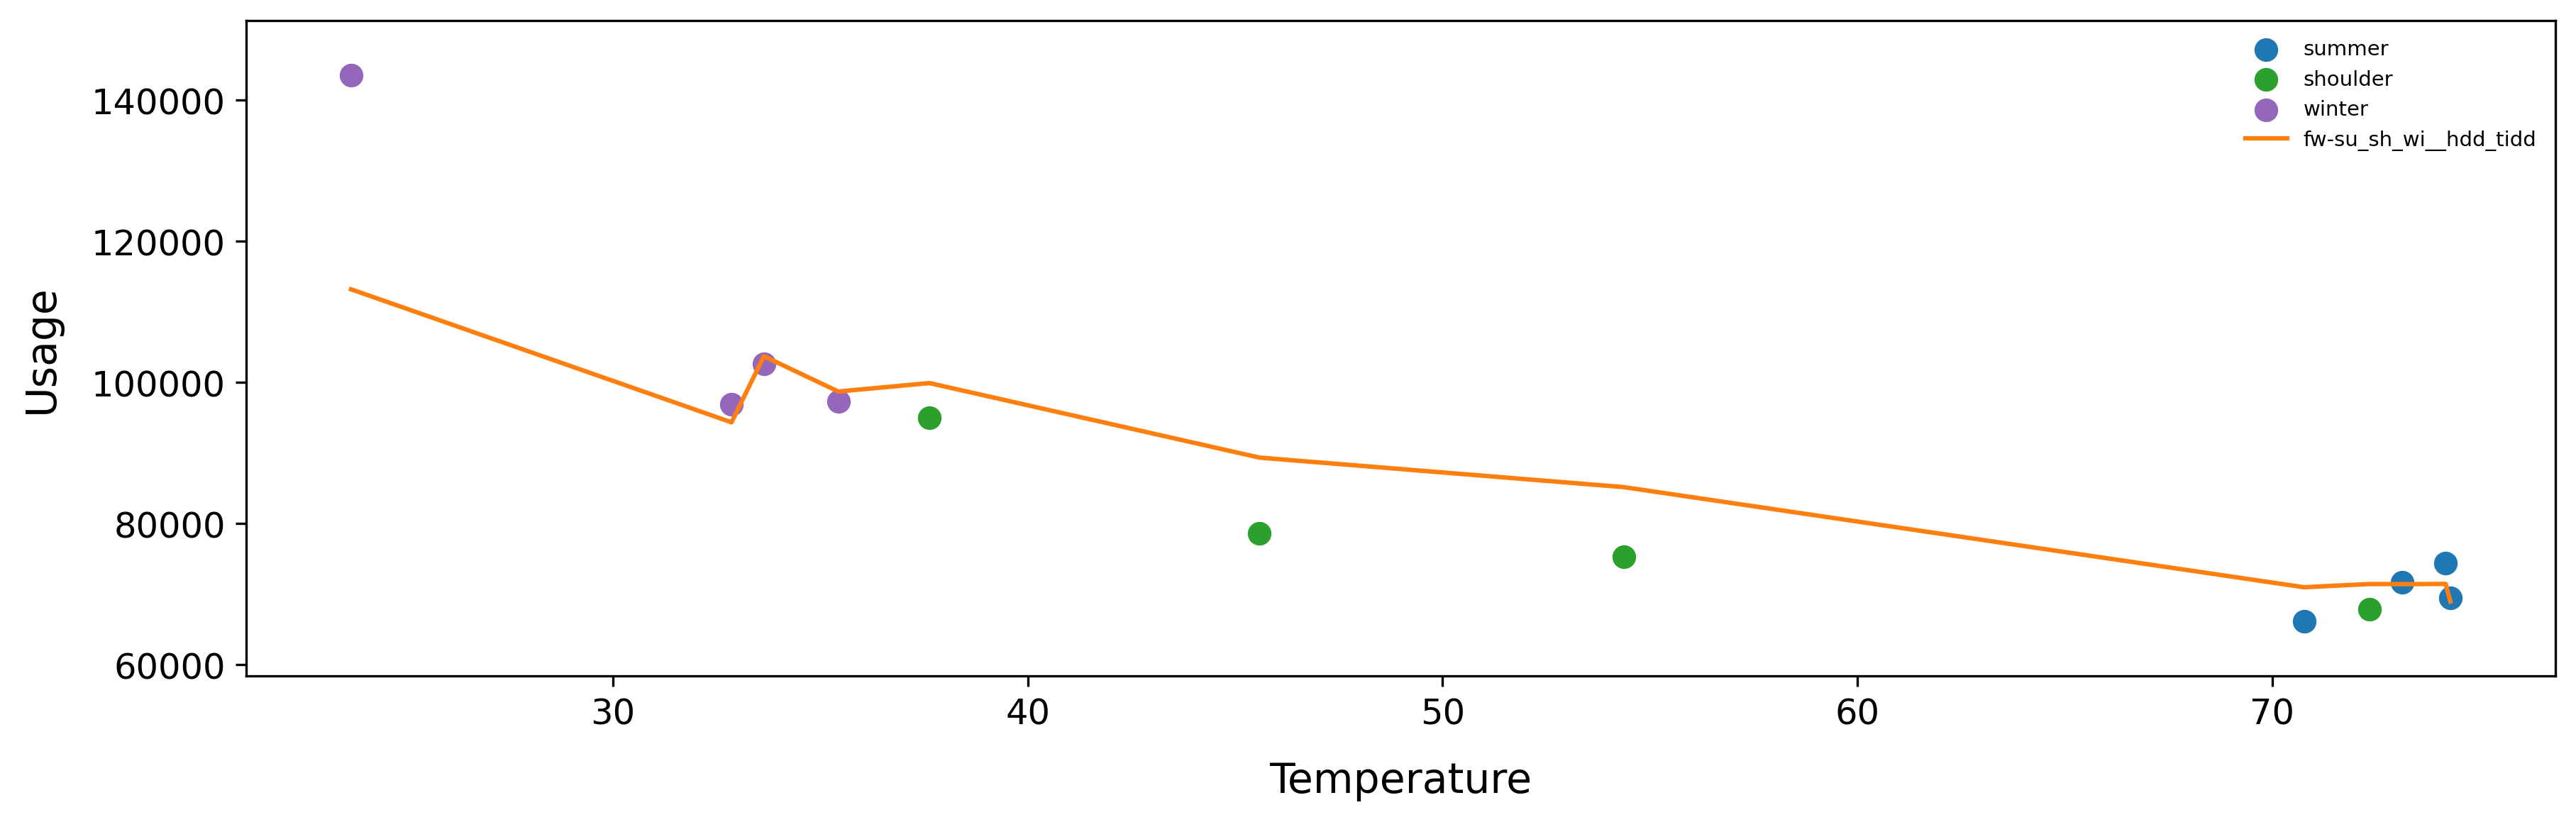

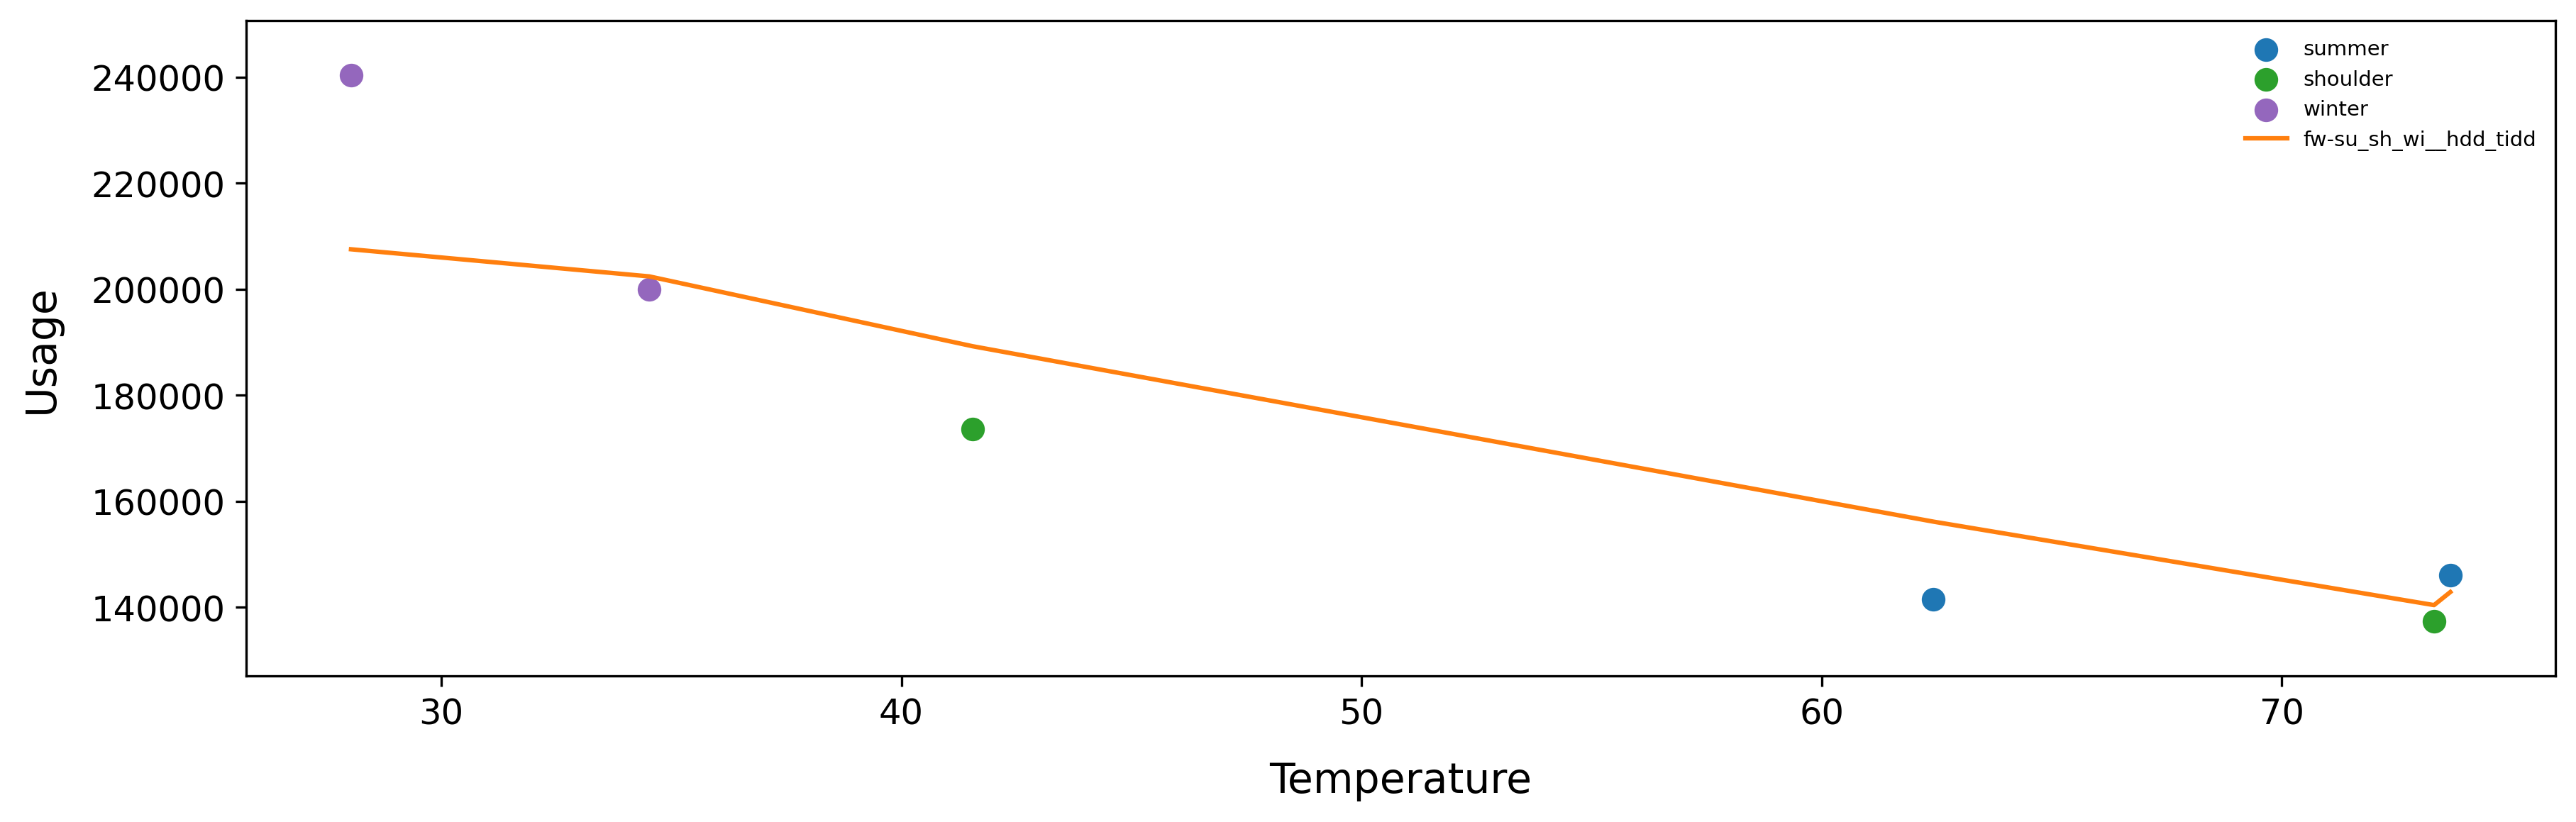

In [19]:
billing_model.plot(billing_baseline_data)

billing_model.plot(billing_baseline_data, aggregation="monthly")

billing_model.plot(billing_baseline_data, aggregation="bimonthly")

## HOURLY Energy Efficiency Model

Just like the daily and billing model, we follow the same calls but for new data classes and model.

In [20]:
df_baseline, df_reporting = odsm.test_data.load_test_data("hourly_treatment_data")

In [21]:
n = 15

id = df_baseline.index.get_level_values(0).unique()[n]

df_baseline_n = df_baseline.loc[id]
df_reporting_n = df_reporting.loc[id]

hourly_baseline_data = em.HourlyBaselineData(df_baseline_n, is_electricity_data=True)
hourly_reporting_data = em.HourlyReportingData(df_reporting_n[["temperature"]], is_electricity_data=True)

hourly_model = em.HourlyModel().fit(hourly_baseline_data)

{'n_extreme_values': 2, 'median': 7.244165859677629, 'upper_quantile': 12.55184370957716, 'lower_quantile': 3.5384346926350125, 'lower_bound': -23.501792358191427, 'upper_bound': 39.5920707604036, 'min_value': 0.487812107473959, 'max_value': 40.06490295571486}
{'n_valid_temperature_data_days': 364, 'n_days_total': nan}
{'n_valid_joint_data_days': 364, 'n_days_total': nan}
{'n_extreme_values': 2, 'median': 7.244165859677629, 'upper_quantile': 12.55184370957716, 'lower_quantile': 3.5384346926350125, 'lower_bound': -23.501792358191427, 'upper_bound': 39.5920707604036, 'min_value': 0.487812107473959, 'max_value': 40.06490295571486}


In [22]:
hourly_model.predict(hourly_baseline_data)

,temperature,observed,date,hour_of_day,interpolated_temperature,interpolated_observed,has_pv,predicted,predicted_unc
2018-01-01 00:00:00-06:00,-5.08,30.336523,2018-01-01,0,False,False,1,28.641114,1.452375
2018-01-01 01:00:00-06:00,-5.98,37.355408,2018-01-01,1,False,False,1,31.911000,1.452375
2018-01-01 02:00:00-06:00,-7.06,39.376695,2018-01-01,2,False,False,1,33.181979,1.452375
2018-01-01 03:00:00-06:00,-7.06,39.911217,2018-01-01,3,False,False,1,33.994147,1.452375
2018-01-01 04:00:00-06:00,-7.06,39.406699,2018-01-01,4,False,False,1,33.966934,1.452375
...,...,...,...,...,...,...,...,...,...
2018-12-31 19:00:00-06:00,33.98,15.388135,2018-12-31,19,False,False,1,12.750305,1.452375
2018-12-31 20:00:00-06:00,33.98,15.261147,2018-12-31,20,False,False,1,13.302752,1.452375
2018-12-31 21:00:00-06:00,33.98,13.970028,2018-12-31,21,False,False,1,13.607822,1.452375
2018-12-31 22:00:00-06:00,33.92,14.095850,2018-12-31,22,False,False,1,13.899139,1.452375


## Hourly Demand Response Model

Finally, we have a demand response model meant to be used for measuring short-term demand response events within `drmeter`, but it too follows the same API structure

In [23]:
df_baseline, df_reporting = odsm.test_data.load_test_data("hourly_treatment_data")

In [24]:
n = 15

id = df_baseline.index.get_level_values(0).unique()[n]

df_baseline_n = df_baseline.loc[id]
df_reporting_n = df_reporting.loc[id]

hourly_baseline_data = dm.BaselineData(df_baseline_n, is_electricity_data=True)
hourly_reporting_data = dm.ReportingData(df_reporting_n[["temperature"]], is_electricity_data=True)

dr_model = dm.Model().fit(hourly_baseline_data)

AttributeError: module 'opendsm.drmeter' has no attribute 'BaselineData'

In [ ]:
dr_model.predict(hourly_baseline_data)

## How to calculate savings or avoided energy use

Savings calculation functions are not provided in `eemeter`, but to calculate basic savings is a summation of the subtraction of reporting year observed from baseline year prediction for 1 year.

- Savings = sum(predicted_baseline - observed_reporting)